In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix
from hmmlearn import hmm

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, LSTM, Input, Concatenate

import multiprocessing
from tqdm import tqdm

from sklearn.metrics.pairwise import euclidean_distances, cosine_distances
from sklearn.impute import SimpleImputer
# Import các thư viện cần thiết
import numpy as np
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.cluster import KMeans
import skfuzzy as fuzz



In [2]:
# Đọc dữ liệu từ file

features = ["duration","protocol_type","service","flag","src_bytes","dst_bytes","land","wrong_fragment","urgent","hot",
          "num_failed_logins","logged_in","num_compromised","root_shell","su_attempted","num_root","num_file_creations","num_shells",
          "num_access_files","num_outbound_cmds","is_host_login","is_guest_login","count","srv_count","serror_rate","srv_serror_rate",
          "rerror_rate","srv_rerror_rate","same_srv_rate","diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count", 
          "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate","dst_host_srv_diff_host_rate","dst_host_serror_rate",
          "dst_host_srv_serror_rate","dst_host_rerror_rate","dst_host_srv_rerror_rate","label","difficulty"]
train_data = pd.read_csv('KDDTrain+.txt', delimiter=',', header=None, names=features)
test_data = pd.read_csv('KDDTest+.txt', delimiter=',', header=None, names=features)
# print(train_data.columns)
# print(test_data.columns)

print("Shape of Training Dataset:", train_data.shape)
print("Shape of Testing Dataset:", test_data.shape)



Shape of Training Dataset: (125973, 43)
Shape of Testing Dataset: (22544, 43)


In [3]:
# Tiền xử lý dữ liệu

def preprocess_data(train_data, test_data):
    # Kết hợp train_data và test_data thành một DataFrame lớn
    combined_data = pd.concat([train_data, test_data], axis=0)

    # Xử lý dữ liệu categorical
    categorical_features = ['protocol_type', 'service', 'flag']
    combined_data = pd.get_dummies(combined_data, columns=categorical_features)

    # Chia dữ liệu thành train_data và test_data sau khi tiền xử lý
    train_data_processed = combined_data[:len(train_data)]
    test_data_processed = combined_data[len(train_data):]

    # Chuyển nhãn tấn công thành nhãn binary (0: Bình thường, 1: Tấn công)
    train_data_processed['label'] = train_data_processed['label'].apply(lambda x: 0 if x == 'normal' else 1)
    test_data_processed['label'] = test_data_processed['label'].apply(lambda x: 0 if x == 'normal' else 1)

    # Chia dữ liệu thành features và labels
    X_train = train_data_processed.drop('label', axis=1).values
    y_train = train_data_processed['label'].values
    X_test = test_data_processed.drop('label', axis=1).values
    y_test = test_data_processed['label'].values

    # Chuẩn hóa dữ liệu
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    return X_train, X_test, y_train, y_test

# Phân chia dữ liệu huấn luyện và kiểm tra
X_train, X_test, y_train, y_test = preprocess_data(train_data, test_data)
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
train_data['label'].value_counts()


C:\Users\Nguyen Cong Luc\AppData\Local\Temp\ipykernel_19560\1741358053.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_processed['label'] = train_data_processed['label'].apply(lambda x: 0 if x == 'normal' else 1)
C:\Users\Nguyen Cong Luc\AppData\Local\Temp\ipykernel_19560\1741358053.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_processed['label'] = test_data_processed['label'].apply(lambda x: 0 if x == 'normal' else 1)


X_train shape: (125973, 123)
X_test shape: (22544, 123)


normal             67343
neptune            41214
satan               3633
ipsweep             3599
portsweep           2931
smurf               2646
nmap                1493
back                 956
teardrop             892
warezclient          890
pod                  201
guess_passwd          53
buffer_overflow       30
warezmaster           20
land                  18
imap                  11
rootkit               10
loadmodule             9
ftp_write              8
multihop               7
phf                    4
perl                   3
spy                    2
Name: label, dtype: int64

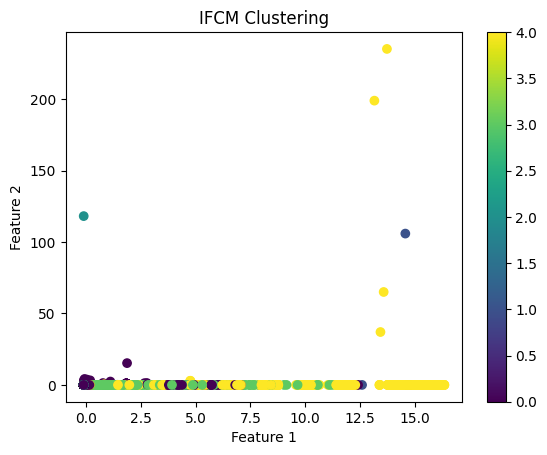

In [21]:
#IFCM và FCAI đều là các thuật toán phân cụm dựa trên lý thuyết tập mờ và sử dụng các đặc điểm của các khoảng giá trị. 
#IFCM tập trung vào việc sử dụng tập mờ khoảng giá trị trong phân cụm, trong khi 
#FCAI kết hợp các phép toán tập hợp mờ và đo độ tương đồng dựa trên khoảng giá trị để phân cụm dữ liệu.
#Lý thuyết tập mờ là mô hình hóa sự không chắc chắn và không rõ ràng trong việc phân loại và quyết định. 
#Thay vì xác định một phần tử thuộc vào một tập hợp duy nhất, lý thuyết tập mờ cho phép phần tử có một mức độ "mờ" của sự thuộc vào tập hợp đó.

"""
IFCM:
Dựa trên lý thuyết tập mờ và giá trị khoảng.
Cho phép mỗi điểm dữ liệu có một giá trị khoảng, không chỉ một giá trị duy nhất.
Phù hợp khi dữ liệu không chính xác hoặc không chắc chắn và có tính chất mờ.
Yêu cầu định nghĩa trước số lượng cụm cần phân chia.
FCAI:
Cũng dựa trên lý thuyết tập mờ và giá trị khoảng.
Tạo ra các cụm dữ liệu dựa trên tính mờ của các điểm dữ liệu.
Cho phép sử dụng các giá trị khoảng để đo đạc sự tương đồng giữa các điểm dữ liệu.
Phù hợp với các tập dữ liệu có tính mờ và không chắc chắn.
DBSCAN:
Dựa trên mật độ dữ liệu và khoảng cách giữa các điểm dữ liệu.
Tìm các vùng dày đặc và phân biệt vùng này với vùng thưa hoặc nhiễu.
Không yêu cầu định nghĩa trước số lượng cụm.
Phù hợp khi dữ liệu có mật độ khác nhau và không chứa các cụm dữ liệu hình thành theo hình cầu."""

def ifcm_clustering(X, clusters, fuzziness, max_iter=100):
    # Khởi tạo ma trận U ngẫu nhiên
    U = np.random.rand(X.shape[0], clusters)
    U /= np.sum(U, axis=1)[:, np.newaxis]

    # Vòng lặp
    for _ in range(max_iter):
        # Cập nhật centroids
        centroids = np.dot(U.T, X) / np.sum(U, axis=0)[:, np.newaxis]

        # Tính khoảng cách giữa các điểm dữ liệu và centroids
        distances = pairwise_distances_argmin_min(X, centroids)

        # Cập nhật ma trận U
        U_new = np.zeros_like(U)
        for i in range(X.shape[0]):
            U_new[i, distances[0][i]] = 1

        # Cập nhật ma trận U theo mức mờ
        U_new = U_new ** fuzziness
        U_new /= np.sum(U_new, axis=1)[:, np.newaxis]

        # Kiểm tra điều kiện dừng
        if np.allclose(U, U_new):
            break

        U = U_new

    # Gán nhãn cho các điểm dữ liệu
    labels = np.argmax(U, axis=1)

    return labels

# Sử dụng thuật toán IFCM để phân cụm dữ liệu X_train
X_train_labels = ifcm_clustering(X_train, clusters=5, fuzziness=2)
# Vẽ biểu đồ phân cụm
plt.scatter(X_train[:, 0], X_train[:, 1], c=X_train_labels, cmap='viridis')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('IFCM Clustering')
plt.colorbar()
plt.show()


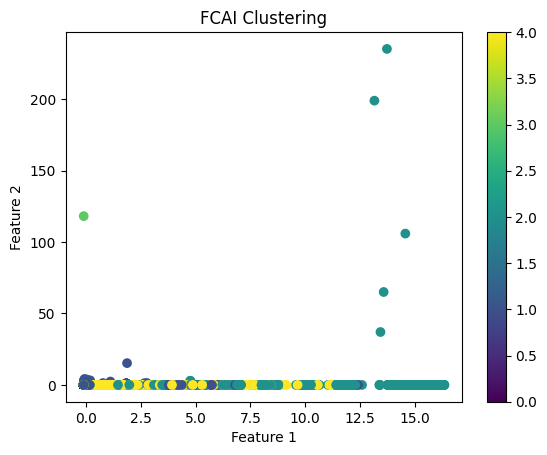

In [22]:
def fcai_clustering(X, fuzziness, max_iter=100):
    # Khởi tạo ma trận U ngẫu nhiên
    U = np.random.rand(X.shape[0], clusters)
    U /= np.sum(U, axis=1)[:, np.newaxis]

    # Vòng lặp
    for _ in range(max_iter):
        # Cập nhật centroids
        centroids = np.dot(U.T, X) / np.sum(U, axis=0)[:, np.newaxis]

        # Tính khoảng cách giữa các điểm dữ liệu và centroids
        distances = pairwise_distances_argmin_min(X, centroids)

        # Cập nhật ma trận U
        U_new = np.zeros_like(U)
        for i in range(X.shape[0]):
            U_new[i, distances[0][i]] = 1

        # Cập nhật ma trận U theo mức mờ
        U_new = U_new ** fuzziness
        U_new /= np.sum(U_new, axis=1)[:, np.newaxis]

        # Kiểm tra điều kiện dừng
        if np.allclose(U, U_new):
            break

        U = U_new

    # Gán nhãn cho các điểm dữ liệu
    labels = np.argmax(U, axis=1)

    return labels

# Sử dụng thuật toán FCAI để phân cụm dữ liệu X_train
X_train_labels = fcai_clustering(X_train, fuzziness=2)
# Vẽ biểu đồ phân cụm
plt.scatter(X_train[:, 0], X_train[:, 1], c=X_train_labels, cmap='viridis')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('FCAI Clustering')
plt.colorbar()
plt.show()


In [4]:
# Huấn luyện mô hình CNN (Convolutional Neural Network)
#CNN (Convolutional Neural Network): Dùng để xử lý dữ liệu không gian như ảnh. Sử dụng lớp tích chập để trích xuất đặc trưng từ dữ liệu 
#và thường được sử dụng trong nhận dạng ảnh và phân loại ảnh.



def train_cnn_model(X_train, y_train):
    input_shape = (X_train.shape[1], 1)

    model = Sequential()
    model.add(Conv1D(32, 3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(2))
    model.add(Conv1D(64, 3, activation='relu'))
    model.add(MaxPooling1D(2))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    model.fit(X_train, y_train, epochs=200, batch_size=64)

    return model
"""Epoch là lặp lại toàn bộ dữ liệu để cung cấp cho mô hình cơ hội để học và cải thiện hiệu suất dự đoán.  Nếu lặp lại  quá ít thì mô hình chưa tối ưu, không đạt độ chính xác.
Nếu lặp lại quá nhiều thì overfiting tức nó sẽ không thể tổng quát hóa được và dự đoán kém dữ liệu thực tế hay kiểm tra
 batch_size: số lượng mẫu dữ liệu được truyền qua mạng một thời điểm"""

# Huấn luyện mô hình LSTM (Long Short-Term Memory)
#LSTM (Long Short-Term Memory): Thuộc vào loại RNN. Dùng để xử lý dữ liệu chuỗi có tính tuần tự. Có khả năng lưu giữ thông tin trong thời gian dài và thường được sử dụng trong dịch máy,
#nhận dạng giọng nói và dự đoán chuỗi thời gian

def train_lstm_model(X_train, y_train):
    input_shape = (X_train.shape[1], 1)

    model = Sequential()
    model.add(LSTM(32, input_shape=input_shape))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    model.fit(X_train, y_train, epochs=200, batch_size=64)

    return model
# Huấn luyện mô hình CNN + LSTM
#CNN + LSTM (Convolutional Neural Network + Long Short-Term Memory): Kết hợp ưu điểm của cả hai mô hình CNN và LSTM. 
# Sử dụng CNN để trích xuất đặc trưng từ dữ liệu không gian và LSTM để xử lý dữ liệu chuỗi. Thường được sử dụng trong nhận dạng video, 
# xử lý ngôn ngữ tự nhiên và dự đoán chuỗi thời gian trong dữ liệu hình ảnh.


def train_cnn_lstm_model(X_train, y_train):
    input_shape = (X_train.shape[1], 1)

    # CNN model
    cnn_input = Input(shape=input_shape)
    cnn_layer = Conv1D(32, 3, activation='relu')(cnn_input)
    cnn_layer = MaxPooling1D(2)(cnn_layer)
    cnn_layer = Conv1D(64, 3, activation='relu')(cnn_layer)
    cnn_layer = MaxPooling1D(2)(cnn_layer)
    cnn_layer = Flatten()(cnn_layer)

    # LSTM model
    lstm_input = Input(shape=input_shape)
    lstm_layer = LSTM(32)(lstm_input)

    # Concatenate CNN and LSTM layers
    concat_layer = Concatenate()([cnn_layer, lstm_layer])

    output_layer = Dense(1, activation='sigmoid')(concat_layer)

    model = Model(inputs=[cnn_input, lstm_input], outputs=output_layer)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit([X_train, X_train], y_train, epochs=200, batch_size=64)

    return model
# Hàm huấn luyện mô hình Markov
#Markov Model: Mô hình xác suất dựa trên nguyên tắc Markov. Giả định rằng trạng thái hiện tại chỉ phụ thuộc vào trạng thái trước đó một cách xác định.
#  Sử dụng ma trận chuyển đổi xác suất để biểu diễn các chuyển đổi giữa các tình trạng. 
# Thường được sử dụng trong dự đoán chuỗi thời gian, xử lý ngôn ngữ tự nhiên và các bài toán xếp thứ tự.

def train_markov_model(X_train, y_train):
    model = hmm.GaussianHMM(n_components=2)
    # Tách dữ liệu thành hai lớp: Bình thường (0) và Tấn công (1)
    normal_data = X_train[y_train == 0]
    attack_data = X_train[y_train == 1]
    # Reshape dữ liệu cho phù hợp với yêu cầu của mô hình Markov
    normal_data = np.reshape(normal_data, (-1, 1))
    attack_data = np.reshape(attack_data, (-1, 1))
    # Huấn luyện mô hình trên dữ liệu bình thường
    print("Training Markov model...", end=" ")
    model.fit(normal_data)
    print("\rMarkov    [==============================] - Complete!")
    return model

In [5]:

# Huấn luyện mô hình CNN
cnn_model = train_cnn_model(X_train, y_train)

# Huấn luyện mô hình LSTM
lstm_model = train_lstm_model(X_train, y_train)

# Huấn luyện mô hình CNN + LSTM
cnn_lstm_model = train_cnn_lstm_model(X_train, y_train)

# Huấn luyện mô hình Markov
markov_model = train_markov_model(X_train, y_train)

Epoch 1/200
1969/1969 [==============================] - 19s 9ms/step - loss: 0.0299 - accuracy: 0.9908
Epoch 2/200
1969/1969 [==============================] - 18s 9ms/step - loss: 0.0103 - accuracy: 0.9966
Epoch 3/200
1969/1969 [==============================] - 18s 9ms/step - loss: 0.0070 - accuracy: 0.9975
Epoch 4/200
1969/1969 [==============================] - 18s 9ms/step - loss: 0.0059 - accuracy: 0.9978
Epoch 5/200
1969/1969 [==============================] - 25s 13ms/step - loss: 0.0042 - accuracy: 0.9985
Epoch 6/200
1969/1969 [==============================] - 21s 11ms/step - loss: 0.0039 - accuracy: 0.9986
Epoch 7/200
1969/1969 [==============================] - 18s 9ms/step - loss: 0.0037 - accuracy: 0.9987
Epoch 8/200
1969/1969 [==============================] - 19s 10ms/step - loss: 0.0030 - accuracy: 0.9989
Epoch 9/200
1969/1969 [==============================] - 22s 11ms/step - loss: 0.0028 - accuracy: 0.9989
Epoch 10/200
1969/1969 [==============================] - 20

In [101]:

# Đánh giá hiệu quả từng mô hình
"""Confusion matrix là một công cụ để đánh giá hiệu suất của mô hình phân loại bằng cách so sánh dự đoán của mô hình với giá trị thực tế. Nó là một ma trận hai chiều, 
trong đó các hàng đại diện cho nhãn thực tế và các cột đại diện cho nhãn dự đoán. Các ô trong ma trận biểu thị số lượng các mẫu thuộc từng loại phân loại. 
Qua confusion matrix, ta có thể tính toán các độ đo đánh giá như độ chính xác, độ phủ, độ chuẩn xác, và tỉ lệ nhầm lẫn."""
def evaluate_model(model, X_test, y_test, type):
    if type==1:  y_pred = model.predict([X_test, X_test])
    else: y_pred = model.predict(X_test)
    if y_pred.ndim > 1:
        y_pred = np.argmax(y_pred, axis=1)
    cm = confusion_matrix(y_test, y_pred)
    
    accuracy = np.sum(np.diagonal(cm)) / np.sum(cm)
    return cm, accuracy
print(cnn_model.input_shape)
print(X_test.shape[1])
if X_test.shape[1] == cnn_model.input_shape[1]:
    print("Kích thước đầu vào của mô hình CNN khớp với kích thước của dữ liệu kiểm tra.")
else:
    print("Kích thước đầu vào của mô hình CNN không khớp với kích thước của dữ liệu kiểm tra.")

cnn_cm, cnn_accuracy = evaluate_model(cnn_model, X_test, y_test, 0)
lstm_cm, lstm_accuracy = evaluate_model(lstm_model, X_test, y_test, 0)
cnn_lstm_cm, cnn_lstm_accuracy = evaluate_model(cnn_lstm_model, X_test, y_test, 1)
markov_cm, markov_accuracy = evaluate_model(markov_model, X_test, y_test, 0)


(None, 124, 1)
124
Kích thước đầu vào của mô hình CNN khớp với kích thước của dữ liệu kiểm tra.
705/705 [==============================] - 10s 14ms/step


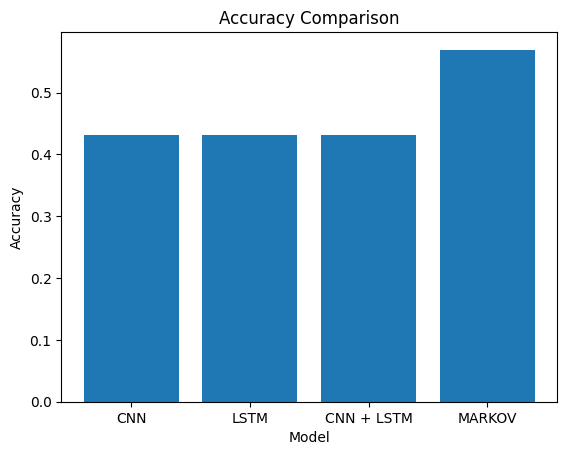

In [102]:
# Hiển thị độ chính xác
model_names = ['CNN', 'LSTM', 'CNN + LSTM', 'MARKOV']
accuracy_scores = [cnn_accuracy, lstm_accuracy, cnn_lstm_accuracy, markov_accuracy]

plt.bar(model_names, accuracy_scores)
plt.title('Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.show()